# Imports

In [1]:
import torch.nn as nn
from torch_geometric.nn import DenseGCNConv
from torch_geometric.datasets import ZINC
from torch_geometric.utils import to_dense_adj
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# RealNVP

## Fully connected neural network for the base network

In [3]:
class FCNN(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, out_dim),
        )
        
    def forward(self, x):
        return self.network(x)

## Flow

In [4]:
class RealNVP(nn.Module):
    def __init__(self, dim, hidden_dim=8, base_network=FCNN):
        super().__init__()
        self.dim = dim
        self.t1 = base_network(dim // 2, dim // 2, hidden_dim)
        self.s1 = base_network(dim // 2, dim // 2, hidden_dim)
        self.t2 = base_network(dim // 2, dim // 2, hidden_dim)
        self.s2 = base_network(dim // 2, dim // 2, hidden_dim)

    def forward(self, x):
        lower, upper = x[:, :self.dim // 2], x[:, self.dim // 2:]
        t1_transformed = self.t1(lower)
        s1_transformed = self.s1(lower)
        upper = t1_transformed + upper * torch.exp(s1_transformed)
        t2_transformed = self.t2(upper)
        s2_transformed = self.s2(upper)
        lower = t2_transformed + lower * torch.exp(s2_transformed)
        z = torch.cat([lower, upper], dim=1)
        log_det = torch.sum(s1_transformed, dim=1) + torch.sum(s2_transformed, dim=1)
        return z, log_det

    def inverse(self, z):
        lower, upper = z[:, :self.dim // 2], z[:, self.dim // 2:]
        t2_transformed = self.t2(upper)
        s2_transformed = self.s2(upper)
        lower = (lower - t2_transformed) * torch.exp(-s2_transformed)
        t1_transformed = self.t1(lower)
        s1_transformed = self.s1(lower)
        upper = (upper - t1_transformed) * torch.exp(-s1_transformed)
        x = torch.cat([lower, upper], dim=1)
        log_det = torch.sum(-s1_transformed, dim=1) + torch.sum(-s2_transformed, dim=1)
        return x, log_det

# GAN

## Generator

In [5]:
class Generator(nn.Module):
    def __init__(
        self,
        input_dim,
        num_nodes,
        num_features, 
        num_edge_types,
    ):
        super().__init__()
        self.input_dim = input_dim
        self.flow_model = RealNVP(input_dim)
        self.num_nodes = num_nodes
        self.num_features = num_features
        self.num_edge_types = num_edge_types
        
        self.adj = nn.Linear(input_dim, num_nodes * num_nodes * (num_edge_types + 1))
        self.feat = nn.Linear(input_dim, num_nodes * num_features)
        
    def forward(self, x):
        # z, _ = self.flow_model(x)
        z = x
        
        adj = self.adj(z).view(x.shape[0], self.num_nodes, self.num_nodes, self.num_edge_types + 1)
        adj = torch.nn.functional.gumbel_softmax(adj, hard=True)
        
        feat = self.feat(z).view(x.shape[0], self.num_nodes, self.num_features)
        feat = torch.nn.functional.gumbel_softmax(feat, hard=True)
        
        
        return adj, feat

## Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self, num_features, num_edge_types):
        super().__init__()
        self.gcns = nn.ModuleList([
            DenseGCNConv(num_features, 1) for _ in range(num_edge_types)
        ])
        self.activation = torch.nn.Sigmoid()
        
    def forward(self, adj, x):
        out = self.gcns[0](x, (adj[:, :, :, 0] - 1).abs())
        for edge_type, gcn in enumerate(self.gcns[1:]):
            out += gcn(x, adj[:, :, :, edge_type + 1])
        return self.activation(out.mean(1))

## Reward Network

In [7]:
class RewardNetwork(nn.Module):
    def __init__(self, num_features, num_edge_types):
        super().__init__()
        self.gcns = nn.ModuleList([
            DenseGCNConv(num_features, 1) for _ in range(num_edge_types)
        ])
        self.activation = torch.nn.Sigmoid()
        
    def forward(self, adj, x):
        out = self.gcns[0](x, (adj[:, :, :, 0] - 1).abs())
        for edge_type, gcn in enumerate(self.gcns[1:]):
            out += gcn(x, adj[:, :, :, edge_type + 1])
        return self.activation(out.mean())

# Rewards

In [8]:
def validity_score(predictions):
    '''
    Validity is defined as the ratio between the number of valid and all generated molecules.
    '''
    predictions[predictions > 0.5] = 1
    predictions[predictions <= 0.5] = 0
    return predictions.sum() / predictions.size(0)

def novelty_score(real_samples, generated_samples):
    '''
    Novelty measures the ratio between the set of valid samples that are not in the dataset and the total number of valid samples.
    '''
    pass

def uniqueness_score(discriminator_output, generated_adj):
    '''
    Uniqueness is defined as the ratio between the number of unique samples and valid samples and it measures the degree of variety during sampling.
    '''
    valid_samples = torch.where(out.view(-1) > 0.5)[0]
    unique_samples = generated_adj[valid_samples].unique(dim=0)
    return torch.tensor(unique_samples.size(0) / len(valid_samples)).float()

# Train

## Load dataset

In [9]:
dataset = ZINC('../dataset')

### For now, filter molecules to have the same number of atoms

In [10]:
num_nodes = {}
for mol in dataset:
    if mol.num_nodes not in num_nodes:
        num_nodes[mol.num_nodes] = 0
    num_nodes[mol.num_nodes] += 1

# Select size which has the most samples in the dataset
most_samples = sorted(num_nodes, key=num_nodes.get, reverse=True)[0]

# Filter
dataset = list(filter(lambda mol: mol.num_nodes == most_samples, dataset))

### Convert atom type to one-hot vector

In [11]:
# Find out how many types of atoms we have in the dataset
num_node_types = 0
for mol in dataset:
    num_node_types = max(int(mol.x.max()), num_node_types)
num_node_types += 1

for mol in dataset:
    new_x = torch.zeros(mol.num_nodes, num_node_types)
    for i, atom_type in enumerate(mol.x):
        new_x[i] = torch.eye(num_node_types)[atom_type]
    mol.x = new_x

### Convert from torch geometric data to torch tensor

In [12]:
# An adjacency matrix where adj_ij = 1 if i and j don't have a bond
real_connections = torch.stack([(~to_dense_adj(mol.edge_index)[0].bool()).float() for mol in dataset])

# Adjacency matrix for a type specific bonds (each type of bond has its own adjacency matrix)
real_type_specific_connections = {edge_type: [] for edge_type in range(1, 3 + 1)}
for mol in tqdm(dataset):
    for edge_type in range(1, 3 + 1):
        try:
            real_type_specific_connections[edge_type].append(to_dense_adj(mol.edge_index[:, torch.where(mol.edge_attr == edge_type)[0]], max_num_nodes=mol.num_nodes)[0])
        except:
            real_type_specific_connections[edge_type].append(torch.zeros(mol.num_nodes, mol.num_nodes))
real_type_specific_connections = {
    edge_type: torch.stack(real_type_specific_connections[edge_type])
    for edge_type in range(1, 1 + 3)
}

100%|██████████| 20444/20444 [01:36<00:00, 211.36it/s]


In [13]:
real_feats = torch.stack([mol.x for mol in dataset]).to(device)
real_adj = torch.stack([real_connections, *[real_type_specific_connections[edge_type] for edge_type in range(1, 3 + 1)]], dim=-1).to(device)

## Initialize models

In [14]:
DISTRIBUTION_DIM = 64
MOL_SIZE = dataset[0].num_nodes
NUM_FEATURES = dataset[0].num_node_features
NUM_EDGE_TYPES = 3

In [15]:
# Gaussian distribution with mean=0 and std=1 as prior distribution
prior = torch.distributions.MultivariateNormal(torch.zeros(DISTRIBUTION_DIM), torch.eye(DISTRIBUTION_DIM))

# Generator
generator = Generator(DISTRIBUTION_DIM, MOL_SIZE, NUM_FEATURES, NUM_EDGE_TYPES).to(device)

# Discriminator
discriminator = Discriminator(NUM_FEATURES, NUM_EDGE_TYPES).to(device)

# Reward Network
reward_network = RewardNetwork(NUM_FEATURES, NUM_EDGE_TYPES).to(device)

### Before training

In [16]:
adj, feat = generator(prior.sample((1000,)).to(device))
out = discriminator(adj, feat)
print('Validity Score:', validity_score(out).item())
print('Uniqueness Score:', uniqueness_score(out, adj).item())

Validity Score: 0.5419999957084656
Uniqueness Score: 1.0


## Training loop (With early stopping on Generator loss)

In [17]:
generator_optimizer = torch.optim.RMSprop(generator.parameters())
discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters())
reward_optimizer = torch.optim.RMSprop(reward_network.parameters())

REWARD_FUNCTION = 'validity'

EARLY_STOPPING_PATIENCE = 20
EARLY_STOPPING_VALUE = 0.001
FAKE_BATCH_SIZE = real_adj.size(0)
REWARD_TRAINING_START_AFTER = 10

best_discriminator = {
    'loss': float('inf'),
    'model_state': None
}

best_generator = {
    'loss': float('inf'),
    'model_state': None
}

best_reward = {
    'loss': float('inf'),
    'model_state': None
}

discriminator_losses = []
generator_losses = []
reward_losses = []

current_patience = EARLY_STOPPING_PATIENCE
epoch = 1
while True:
    ############ Discriminator ############
    discriminator.train()
    discriminator_optimizer.zero_grad()
    
    # Pass real samples to the discriminator
    out = discriminator(real_adj, real_feats)
    # Get the loss
    ground_truth = torch.ones(real_adj.size(0), 1).to(device)
    discriminator_loss = torch.nn.functional.l1_loss(out, ground_truth)
        
    # Pass fake samples to the discriminator
    fake_adj, fake_feat = generator(prior.sample((FAKE_BATCH_SIZE,)).to(device))
    out = discriminator(fake_adj, fake_feat)
    # Get the loss
    ground_truth = torch.zeros(FAKE_BATCH_SIZE, 1).to(device)
    discriminator_loss += torch.nn.functional.l1_loss(out, ground_truth)

    # Save best discriminator model
    if discriminator_loss < best_discriminator['loss']:
        best_discriminator['loss'] = discriminator_loss.item()
        best_discriminator['model_state'] = discriminator.state_dict()
    
    # Keep track of loss at each step
    discriminator_losses.append(discriminator_loss.item())
    
    # Back propagation
    
    discriminator_loss.backward()
    discriminator_optimizer.step()
    
    # reward_loss.backward()
    # reward_optimizer.step()
    
    
    ############ Generator ############
    generator.train()
    generator_optimizer.zero_grad()
    
    reward_network.train()
    reward_optimizer.zero_grad()

    # Generate fake samples
    fake_adj, fake_feat = generator(prior.sample((FAKE_BATCH_SIZE,)).to(device))
    
    # Pass fake samples to discriminator
    out = discriminator(fake_adj, fake_feat)
    
    # Get the loss
    ground_truth = torch.ones(FAKE_BATCH_SIZE, 1).to(device)
    generator_loss = torch.nn.functional.l1_loss(out, ground_truth)
    
    # Keep track of loss at each step
    generator_losses.append(generator_loss.item())

    
    # Save best generator model
    if generator_loss < best_generator['loss']:
        best_generator['loss'] = generator_loss.item()
        best_generator['model_state'] = generator.state_dict()


    if epoch > REWARD_TRAINING_START_AFTER:
        if REWARD_FUNCTION == 'validity':
            reward_ground_truth = validity_score(out.clone())
        elif REWARD_FUNCTION == 'uniqueness':
            reward_ground_truth = uniqueness_score(out.clone(), fake_adj)
        elif REWARD_FUNCTION == 'novelty_score':
            pass
            reward_ground_truth = uniqueness_score(out.clone(), adj)
        reward = reward_network(fake_adj, fake_feat)
        reward_loss = torch.nn.functional.l1_loss(reward, reward_ground_truth)
        reward_losses.append(reward_loss.item())
        generator_loss += reward_loss

        
    if epoch > REWARD_TRAINING_START_AFTER and reward_loss < best_reward['loss']:
        best_reward['loss'] = reward_loss.item()
        best_reward['model_state'] = reward_network.state_dict()
        

    # Back propagation
    generator_loss.backward()
    generator_optimizer.step()
    
    if epoch > REWARD_TRAINING_START_AFTER:
        reward_optimizer.step()
    
    # Control training loop
    if min(generator_losses) - generator_losses[-1] > EARLY_STOPPING_VALUE:
        current_patience = EARLY_STOPPING_PATIENCE
    else:
        current_patience -= 1
    if current_patience < 0:
        break

    print(f'Epoch {epoch} - Generator loss: {generator_losses[-1]:.4f}\tDiscriminator loss: {discriminator_losses[-1]:.4f}\tReward loss: {(reward_losses[-1] if len(reward_losses) > 0 else 0):.4f}')
    epoch += 1

Epoch 1 - Generator loss: 0.6222	Discriminator loss: 0.8660	Reward loss: 0.0000
Epoch 2 - Generator loss: 0.6209	Discriminator loss: 0.8243	Reward loss: 0.0000
Epoch 3 - Generator loss: 0.5739	Discriminator loss: 0.8760	Reward loss: 0.0000
Epoch 4 - Generator loss: 0.5214	Discriminator loss: 0.9282	Reward loss: 0.0000
Epoch 5 - Generator loss: 0.4711	Discriminator loss: 0.9656	Reward loss: 0.0000
Epoch 6 - Generator loss: 0.4206	Discriminator loss: 0.9934	Reward loss: 0.0000
Epoch 7 - Generator loss: 0.3696	Discriminator loss: 1.0169	Reward loss: 0.0000
Epoch 8 - Generator loss: 0.3209	Discriminator loss: 1.0335	Reward loss: 0.0000
Epoch 9 - Generator loss: 0.2754	Discriminator loss: 1.0429	Reward loss: 0.0000
Epoch 10 - Generator loss: 0.2371	Discriminator loss: 1.0483	Reward loss: 0.0000
Epoch 11 - Generator loss: 0.2046	Discriminator loss: 1.0498	Reward loss: 0.4397
Epoch 12 - Generator loss: 0.1832	Discriminator loss: 1.0459	Reward loss: 0.2564
Epoch 13 - Generator loss: 0.1666	Dis

### Plot training loss

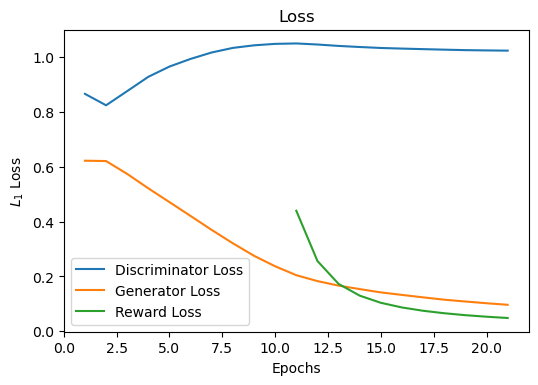

In [18]:
plt.plot(range(1, len(discriminator_losses) + 1), discriminator_losses, label='Discriminator Loss')
plt.plot(range(1, len(generator_losses) + 1), generator_losses, label='Generator Loss')
plt.plot(range(REWARD_TRAINING_START_AFTER + 1, REWARD_TRAINING_START_AFTER + len(reward_losses) + 1), reward_losses, label='Reward Loss')
plt.xlabel('Epochs')
plt.ylabel(r'$L_1$ Loss')
plt.title('Loss')
plt.legend()
plt.gcf().set_dpi(100)
plt.show()

### Load best models

In [19]:
generator.load_state_dict(best_generator['model_state'])
discriminator.load_state_dict(best_discriminator['model_state'])
reward_network.load_state_dict(best_reward['model_state'])

<All keys matched successfully>

In [20]:
adj, feat = generator(prior.sample((1000,)).to(device))
out = discriminator(adj, feat)
print('Validity Score:', validity_score(out).item())
print('Uniqueness Score:', uniqueness_score(out, adj).item())

Validity Score: 1.0
Uniqueness Score: 1.0
